# 1. Import Libraries

In [269]:
#import libraries
import requests
import numpy as np
import json
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
from sklearn.preprocessing import LabelEncoder, StandardScaler
from sklearn.linear_model import LogisticRegression
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.preprocessing import OneHotEncoder
from sklearn.metrics import accuracy_score, precision_score, f1_score,  confusion_matrix
from sklearn.decomposition import PCA
from sklearn.model_selection import train_test_split
from sklearn.metrics import ConfusionMatrixDisplay
import pandas as pd
from shapely.geometry import Point
import geopandas as gpd
from geopandas import GeoDataFrame

# 2.  Data Loading

In [270]:
url = 'https://raw.githubusercontent.com/indrasetiadhip/data-task-sample/main/data-sample.json'
response = requests.get(url)
data = response.json()

df = pd.json_normalize(data)

In [271]:
df.isna().sum()

taskCreatedTime                     0
taskAssignedTo                      1
taskCompletedTime                 768
taskStatus                          0
flow                                0
taskId                              0
taskLocationDone.lon              768
taskLocationDone.lat              768
cod.amount                       5976
cod.received                     5976
UserVar.branch_dest                 0
UserVar.taskStatusLabel           762
UserVar.receiver_city              52
UserVar.taskDetailStatusLabel     762
UserVar.taskDetailStatus          762
UserVar.weight                      0
UserVar.branch_origin             293
UserVar.taskStatus                762
dtype: int64

- there are some null values, most of it because the task was not completed, or simply the customer did not do COD

In [272]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 8334 entries, 0 to 8333
Data columns (total 18 columns):
 #   Column                         Non-Null Count  Dtype  
---  ------                         --------------  -----  
 0   taskCreatedTime                8334 non-null   object 
 1   taskAssignedTo                 8333 non-null   object 
 2   taskCompletedTime              7566 non-null   object 
 3   taskStatus                     8334 non-null   object 
 4   flow                           8334 non-null   object 
 5   taskId                         8334 non-null   object 
 6   taskLocationDone.lon           7566 non-null   float64
 7   taskLocationDone.lat           7566 non-null   float64
 8   cod.amount                     2358 non-null   float64
 9   cod.received                   2358 non-null   object 
 10  UserVar.branch_dest            8334 non-null   object 
 11  UserVar.taskStatusLabel        7572 non-null   object 
 12  UserVar.receiver_city          8282 non-null   o

- the data consists of 18 columns, 8334 rows
- the data have 3 float data type , 15 objects

# 3.  Data Preprocessing for ML

In [273]:
# Convert both columns to datetime format

df[['flow', 'cod.received', 'UserVar.branch_dest','UserVar.receiver_city', 'UserVar.taskDetailStatusLabel','UserVar.weight', 'UserVar.branch_origin']] = df[['flow', 'cod.received', 'UserVar.branch_dest','UserVar.receiver_city', 'UserVar.taskDetailStatusLabel','UserVar.weight', 'UserVar.branch_origin']].astype(str)
df[['flow', 'cod.received', 'UserVar.branch_dest','UserVar.receiver_city', 'UserVar.taskDetailStatusLabel','UserVar.weight', 'UserVar.branch_origin']] = df[['flow', 'cod.received', 'UserVar.branch_dest','UserVar.receiver_city', 'UserVar.taskDetailStatusLabel','UserVar.weight', 'UserVar.branch_origin']].astype(str)

df['taskCompletedTime'] = pd.to_datetime(df['taskCompletedTime'], utc = True)
df['taskCreatedTime'] = pd.to_datetime(df['taskCreatedTime'], utc = True)

df['taskCompletedTime'] = df['taskCompletedTime'].dt.tz_convert(None)
df['taskCreatedTime'] = df['taskCreatedTime'].dt.tz_convert(None)

# Calculate the difference between the two columns
df['time_difference'] = df['taskCompletedTime'] - df['taskCreatedTime']

# Convert timedelta values in the time_difference column to seconds
df['time_difference_seconds'] = df['time_difference'].dt.total_seconds()


df_ml = df[(df['taskStatus']=='done') & (df['taskCompletedTime'].notna()) & \
           (df['UserVar.receiver_city'].notna()) & (df['UserVar.branch_origin'].notna())]\
            .drop(columns=['UserVar.taskStatus', 'UserVar.taskDetailStatus', 'taskAssignedTo','taskCreatedTime','taskCompletedTime',
                           'time_difference','taskId'])

df_ml = df_ml[~((df_ml['UserVar.taskStatusLabel']=='Failed') & (df_ml['cod.amount'].isna()))]


def fill_unknown_condition(taskstatus, taskstatuslabel):
    if taskstatus == 'done' and taskstatuslabel == 'Success':
        return 'no_cod'
    else:
        return 'cod_unsuccess'

df_ml['cod.received'] = df_ml.apply(
    lambda row: row['cod.received'] if pd.notnull(row['cod.received'])
    else fill_unknown_condition(row['taskStatus'], row['UserVar.taskStatusLabel']),
    axis=1
)


df_ml['cod.amount'] = df_ml['cod.amount'].fillna(0)

df_ml = df_ml.drop(columns=['taskStatus'])

- only the data that have task status done is choosen and completed is not null are choosen
- some columns are removed becuse it will not be used, or have the same interpretation as another column
- cod amount that have no value is filled with 0


# 4. Data Visualization

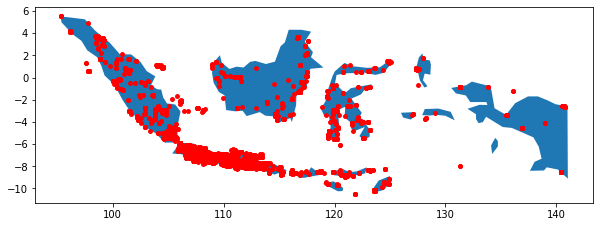

In [274]:
df_filtered = df_ml[(df_ml['taskLocationDone.lon']!=0) & (df_ml['taskLocationDone.lat']!=0)]

geometry = [Point(xy) for xy in zip(df_filtered['taskLocationDone.lon'], df_filtered['taskLocationDone.lat'])]
gdf = GeoDataFrame(df_filtered, geometry=geometry)  


#this is a simple map that goes with geopandas
indonesia = gpd.read_file(gpd.datasets.get_path('naturalearth_lowres'))
indonesia = indonesia[indonesia['name'] == 'Indonesia']
gdf.plot(ax=indonesia.plot(figsize=(10, 6)), marker='o', color='red', markersize=15);

- most of the location done is from Java Island, the 2nd most is from sumatra island.
- Papua island have the least number of task location done

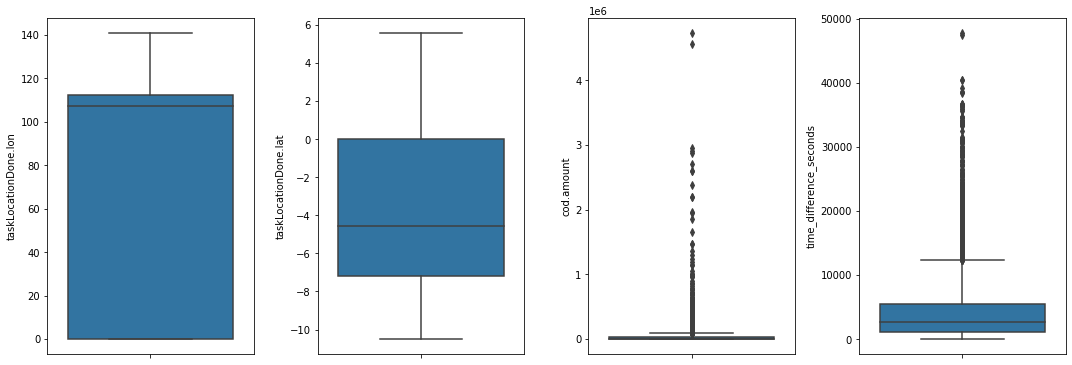

In [275]:
#select numerical features only
nums=df_ml.select_dtypes(['int64','float64']).columns

#visualize data with boxplot
plt.figure(figsize=(15,10))
for i in range(0,len(nums)):
    plt.subplot(2,4,i+1)
    sns.boxplot(y=df_ml[nums[i]],orient ='v')
    plt.tight_layout()

- COD Amount, time difference in seconds have outliers
- While task location done lon and lat does not have it, but keep in mind that long and lat is actually just a location/positon

In [276]:
#took numerical data
nums2=df_ml.select_dtypes(include=['int64','float64'])

#look for outliers in numerical data
for i, x in nums2.items():
    q1 = x.quantile(0.25)
    q3 = x.quantile(0.75)
    iqr = q3 - q1
    xcol = x[(x <= q1 - 1.5 * iqr) | (x >= q3 + 1.5 * iqr)]
    perc = np.shape(xcol)[0] * 100.0/np.shape(nums2)[0]
    print("Column %s outliers = %.2f%%" % (i, perc))
    
# i = name of columns

Column taskLocationDone.lon outliers = 0.00%
Column taskLocationDone.lat outliers = 0.00%
Column cod.amount outliers = 18.89%
Column time_difference_seconds outliers = 11.82%


- COD Amount have around 18.9% outliers, while time difference seconds have around 11.8% outliers


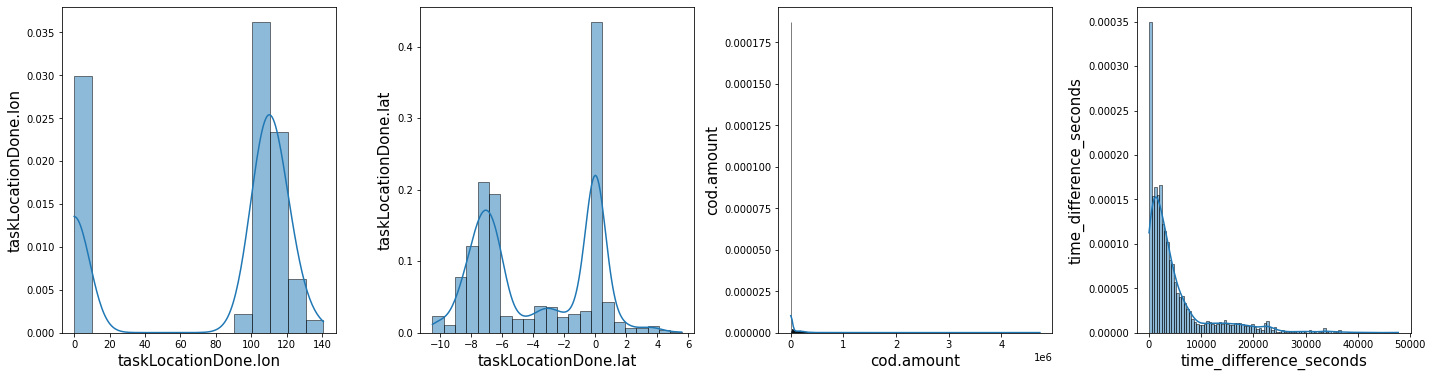

In [277]:
#visualize data with dist plot
plt.figure(figsize=(20, 10))
for i in range(0, len(nums)):
    plt.subplot(2,4, i+1)
    sns.histplot(df_ml[nums[i]], kde=True, stat="density", linewidth=0.5)
    plt.tight_layout()
    plt.xlabel(nums[i],fontsize=15)
    plt.ylabel(nums[i],fontsize=15)


- irregular distributin - longitude and latitude
- Negatively skewed: Time difference seconds, cod amount

In [278]:
df_ml['UserVar.taskStatusLabel'].value_counts()

UserVar.taskStatusLabel
Success    5421
Failed     1235
Name: count, dtype: int64

- The Task status label will be used as target variable for modelling
- The succes count is 5431 and failed is 1235

# 5. Data Preprocessing For Modelling

In [279]:
#label encoding target data
dfc=df_ml.copy()

lb_make = LabelEncoder()
dfc["UserVar.taskStatusLabel"] = lb_make.fit_transform(dfc["UserVar.taskStatusLabel"])

In [280]:
#separate target and features
x=dfc.drop(columns=['UserVar.taskStatusLabel'])
y=dfc['UserVar.taskStatusLabel']

#split dataset
xtrain,xtest, ytrain, ytest= train_test_split(x,y, train_size=0.7, random_state=42, stratify = y)

In [281]:
# Separate numerical and categorical features
numerical_features = xtrain.select_dtypes(include=['number'])
categorical_features = xtrain.select_dtypes(exclude=['number'])

numerical_features_test = xtest.select_dtypes(include=['number'])
categorical_features_test =xtest.select_dtypes(exclude=['number'])

# Standardize the numerical features
scaler = StandardScaler()
X_train_num = scaler.fit_transform(numerical_features)
X_test_num = scaler.transform(numerical_features_test)

# Encode the categorical features
encoder = OneHotEncoder(handle_unknown='ignore')
X_train_cat = encoder.fit_transform(categorical_features)
X_test_cat = encoder.transform(categorical_features_test)

# Combine preprocessed numerical and categorical features
X_train_preprocessed = pd.concat([pd.DataFrame(X_train_num, index=numerical_features.index, columns=numerical_features.columns), 
                                   pd.DataFrame(X_train_cat.toarray(), index=categorical_features.index, columns=encoder.get_feature_names_out(categorical_features.columns))], axis=1)
X_test_preprocessed = pd.concat([pd.DataFrame(X_test_num, index=numerical_features_test.index, columns=numerical_features_test.columns), 
                                  pd.DataFrame(X_test_cat.toarray(), index=categorical_features_test.index, columns=encoder.get_feature_names_out(categorical_features_test.columns))], axis=1)


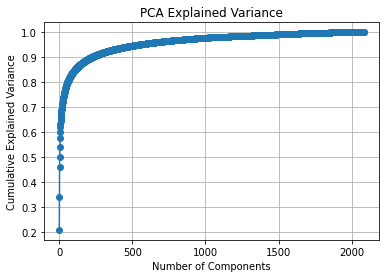

Best number of components (elbow method): 11


In [282]:
# Apply PCA to the preprocessed data
pca = PCA()
X_train_pca = pca.fit_transform(X_train_preprocessed)
X_test_pca = pca.transform(X_test_preprocessed)

# Plot the explained variance ratio for each component
explained_variance_ratio = pca.explained_variance_ratio_
cumulative_explained_variance = np.cumsum(explained_variance_ratio)
plt.plot(range(1, len(explained_variance_ratio) + 1), cumulative_explained_variance, marker='o')
plt.xlabel('Number of Components')
plt.ylabel('Cumulative Explained Variance')
plt.title('PCA Explained Variance')
plt.grid()
plt.show()

# Determine the best number of components using the elbow method
best_n_components = None
for i in range(1, len(cumulative_explained_variance)):
    if cumulative_explained_variance[i] - cumulative_explained_variance[i-1] < 0.01:
        best_n_components = i
        break

if best_n_components is None:
    print("No suitable number of components found using the elbow method.")
else:
    print(f"Best number of components (elbow method): {best_n_components}")

In [283]:
# Apply PCA to the preprocessed data
pca = PCA(250)
X_train_pca = pca.fit_transform(X_train_preprocessed)
X_test_pca = pca.transform(X_test_preprocessed)

- All of the features have decent correlation with the target features

# 6. Define Model

In [284]:
#define models
lr=LogisticRegression()
tree=DecisionTreeClassifier()

# 7. Train Model

In [285]:
#fit model
lr.fit(X_train_pca, ytrain)
tree.fit(X_train_pca, ytrain)

DecisionTreeClassifier()

# 8. Evaluate Model

### Logistic Regression

In [286]:
#predict train and test data
ypred_train_log = lr.predict(X_train_pca)
ypred_test_log=lr.predict(X_test_pca)

In [287]:
#model evaluation

print('Accuracy Score Train:',accuracy_score(ytrain, ypred_train_log))
print('Accuracy Score Test:',accuracy_score(ytest, ypred_test_log))
print('Precision Score Train:',precision_score(ytrain, ypred_train_log))
print('Precision Score Test:',precision_score(ytest, ypred_test_log))
print('F-1Score:', f1_score(ytest, ypred_test_log))

Accuracy Score Train: 0.9997853616655935
Accuracy Score Test: 1.0
Precision Score Train: 1.0
Precision Score Test: 1.0
F-1Score: 1.0


- Train Accuracy Score: 0.9997853616655935 - The model is accurately classifying around 99.98% of the training data, indicating that it has learned the underlying patterns in the training set very well.
- Test Accuracy Score: 1.0 - The model is correctly classifying all of the test data, suggesting that it is generalizing well to unseen data.
- Train Precision Score: 1.0 - The model has a perfect precision score on the training data, which means that when the model predicts a positive class, it is always correct.
- Test Precision Score: 1.0 - The model also has a perfect precision score on the test data, indicating that it is always correct when predicting a positive class.
- F-1 Score: 1.0 - The F1-score, which is the harmonic mean of precision and recall, is 1.0. This means that the model has perfect precision and recall, accurately predicting positive instances and capturing all actual positive instances in the data.

But this perfect result is rare in real world case, it could be overfitting, or the data is not complex, or the model may be unsuitable

### Decision Tree

In [288]:
#predict train and test data
ypred_train_tree = tree.predict(X_train_pca)
ypred_test_tree=tree.predict(X_test_pca)

In [289]:
#model evaluation
print('Accuracy Score Train:',accuracy_score(ytrain, ypred_train_tree))
print('Accuracy Score Test:',accuracy_score(ytest, ypred_test_tree))
print('Precision Score Train:',precision_score(ytrain, ypred_train_tree))
print('Precision Score Test:',precision_score(ytest, ypred_test_tree))
print('F-1Score:', f1_score(ytest, ypred_test_tree))

Accuracy Score Train: 1.0
Accuracy Score Test: 0.9934902353530295
Precision Score Train: 1.0
Precision Score Test: 0.9969192852741836
F-1Score: 0.9959987688519544


- Accuracy Score Train: 1.0 - The model correctly classifies 100% of the training data, indicating that the model has learned the underlying patterns in the training set perfectly.
- Accuracy Score Test: 0.993 - The model correctly classifies approximately 99.3% of the test data, suggesting that the model is generalizing well to the unseen data in the test set.
- Precision Score Train: 1.0 - The model has a perfect precision score on the training data, which means that when the model predicts a positive class, it is always correct.
- Precision Score Test: 0.997 - The model has a high precision score of approximately 99.6% on the test data, indicating that when the model predicts a positive class in the test set, it is almost always correct.
- F-1 Score: 0.996 - The F1-score is the harmonic mean of precision and recall, which is approximately 99.6% in this case. A score of 1.0 indicates perfect precision and recall, meaning that when the model predicts a positive class, it is always correct, and it captures all the actual positive instances in the data.

But this perfect result is rare in real world case, it could be overfitting, or the data is not complex, or the model may be unsuitable

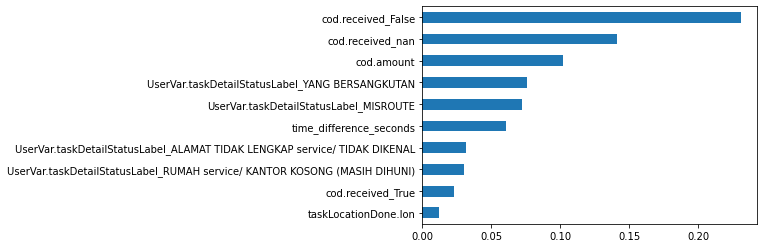

In [290]:
#show top 10 feature importance
forest=RandomForestClassifier()
forest.fit(X_train_preprocessed, ytrain)
feat_importances = pd.Series(forest.feature_importances_, index=X_train_preprocessed.columns)
feat_importances.nlargest(10).plot(kind='barh').invert_yaxis()

- The top 3 most affecting features on the predictions is cod.received false, code.received_nan, and cod.amount.

## Model Insight:

- The model is overfitting
- We should try hyperparamter tuning
- The data should be adjustable more, like removing outliers, or trying different approach of selecting features.